In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os
import json
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query
import plotly.graph_objects as go

# always make it pretty 
plt.style.use('ggplot')

In [2]:
db = global_connect()

## Load data

**Drivers General**

In [3]:
#df = careful_query('SELECT * FROM driver')
df = careful_query("""
SELECT *
FROM driver
WHERE driver_id in (SELECT DISTINCT(driver_id) FROM itineraries WHERE distribution_center1=2)
""")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   driver_id            1597 non-null   object        
 1   distribution_center  1597 non-null   int64         
 2   min_sent             1597 non-null   datetime64[ns]
 3   max_sent             1597 non-null   datetime64[ns]
 4   avg_hour             1597 non-null   float64       
 5   std_hour             1579 non-null   float64       
 6   pushes               1597 non-null   int64         
 7   itineraries          1597 non-null   int64         
 8   avg_lat              1597 non-null   float64       
 9   avg_lng              1597 non-null   float64       
 10  std_lat              1579 non-null   float64       
 11  std_lng              1579 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int64(3), object(1)
memory usage: 149.8+ KB


In [4]:
df_d = careful_query("""
select driver_id, 
--    sum(day_total_sent) as total_sent,
--    sum(day_total_sent_with_it) as total_sent_with_it,
    sum(day_distance) as total_distance, 
    sum(day_distance_with_it) as total_distance_with_it, 
    avg(day_distance) as avg_day_distance, 
    avg(day_distance_with_it) as avg_day_distance_with_it, 
    stddev(day_distance) as std_day_distance,    
    stddev(day_distance_with_it) as std_day_distance_with_it
from driver_day_distance ddd 
group by driver_id;""")

In [5]:
df = df.merge(df_d, left_on='driver_id', right_on='driver_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1595 entries, 0 to 1594
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   driver_id                 1595 non-null   object        
 1   distribution_center       1595 non-null   int64         
 2   min_sent                  1595 non-null   datetime64[ns]
 3   max_sent                  1595 non-null   datetime64[ns]
 4   avg_hour                  1595 non-null   float64       
 5   std_hour                  1577 non-null   float64       
 6   pushes                    1595 non-null   int64         
 7   itineraries               1595 non-null   int64         
 8   avg_lat                   1595 non-null   float64       
 9   avg_lng                   1595 non-null   float64       
 10  std_lat                   1577 non-null   float64       
 11  std_lng                   1577 non-null   float64       
 12  total_distance      

In [6]:
df['min_sent'] = pd.to_datetime(df['min_sent'])
df['max_sent'] = pd.to_datetime(df['max_sent'])

In [18]:
df['days'] = df.max_sent - df.min_sent
df['days'] = df['days'].apply(lambda x: x.days if x.days > 0 else 1)

In [19]:
df['distance_per_day'] = df['total_distance'] / df['days']

In [23]:
df['itineraries'] = df.itineraries.apply(lambda x: x if x > 0 else 1)
df['dist_per_itinerary'] = df['total_distance_with_it'] / df['itineraries']

In [24]:
df.describe()

distribution_center     avg_hour     std_hour        pushes  \
count          1595.000000  1595.000000  1577.000000   1595.000000   
mean              1.559248    10.895374     3.382173   3804.335423   
std               0.496633     2.027844     1.562586   8512.273992   
min               1.000000     3.000000     0.000000      1.000000   
25%               1.000000     9.668196     2.448648     58.000000   
50%               2.000000    10.832061     3.313706    460.000000   
75%               2.000000    12.006165     4.282013   2777.000000   
max               2.000000    22.000000    10.952739  69790.000000   

       itineraries      avg_lat      avg_lng      std_lat      std_lng  \
count  1595.000000  1595.000000  1595.000000  1577.000000  1577.000000   
mean     40.922257   -23.552924   -46.546768     0.018234     0.022262   
std      62.558552     0.065882     0.030290     0.006055     0.007335   
min       1.000000   -23.650536   -46.616276     0.000002     0.000002   
25%       3.000000   -23.611308   -46.571017     0.014138     0.017814   
50%      14.000000   -23.588446   -46.547115     0.018844     0.023310   
75%      57.000000   -23.479900   -46.520409     0.022586     0.027440   
max     945.000000   -23.423685   -46.468287     0.038264     0.044000   

       total_distance  total_distance_with_it  avg_day_distance  \
count     1595.000000             1595.000000       1595.000000   
mean      2769.418997              395.250601         15.935649   
std       3302.122651              342.877393          7.996699   
min          4.443712                0.000000          1.224735   
25%        580.513369              118.879556         10.029615   
50%       1376.892221              296.366007         14.052906   
75%       3901.890592              578.783719         20.476314   
max      25768.831160             1906.069160         62.093569   

       avg_day_distance_with_it  std_day_distance  std_day_distance_with_it  \
count               1595.000000       1593.000000               1593.000000   
mean                   3.965974         13.233391                  7.043671   
std                    3.818717          4.716092                  3.576355   
min                    0.000000          1.844769                  0.000000   
25%                    1.323522          9.687342                  4.449621   
50%                    2.487337         12.628639                  6.350791   
75%                    5.367981         16.192675                  9.145042   
max                   21.854155         31.957387                 21.822523   

              days  distance_per_day  dist_per_itinerary  
count  1595.000000       1595.000000         1595.000000  
mean    229.794357        140.645772           92.450289  
std     148.495987        863.323470          200.100914  
min       1.000000          0.081105            0.000000  
25%     101.000000          3.851758            5.243224  
50%     214.000000          9.031269            8.574298  
75%     393.000000         18.484285           77.969132  
max     434.000000      16907.384777         1777.301231

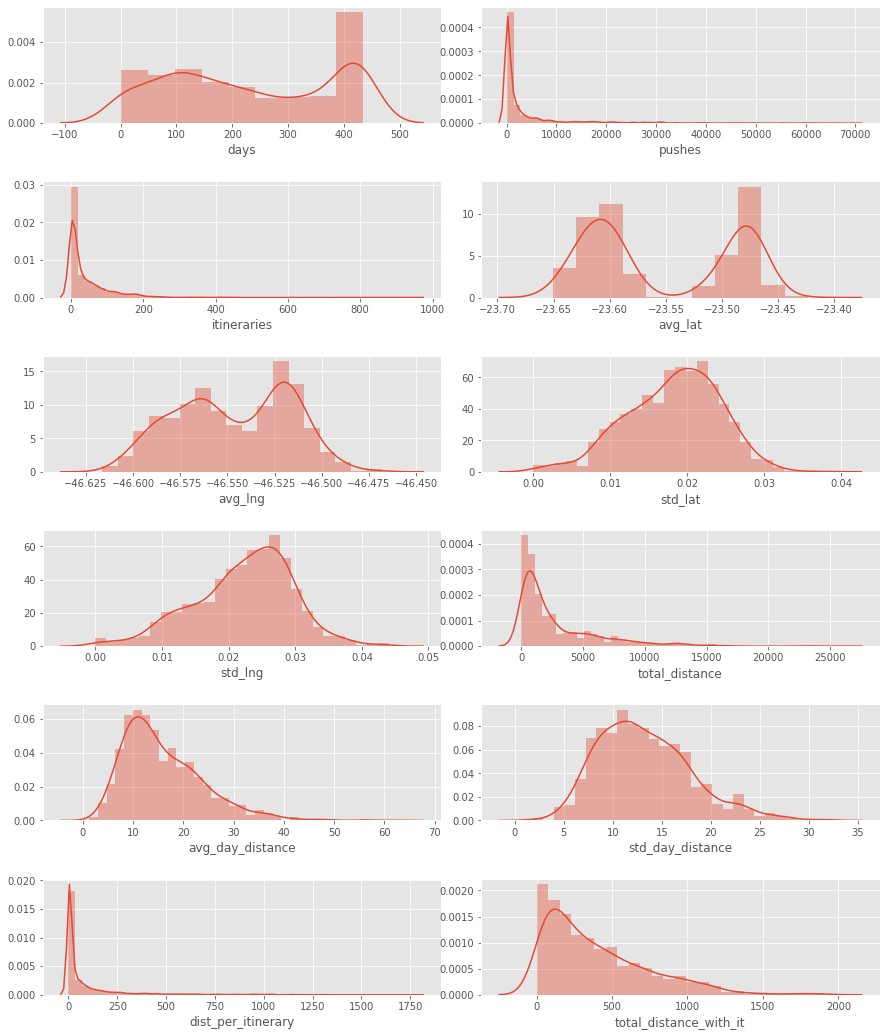

In [26]:
cols = ['days', 'pushes', 'itineraries', 'avg_lat', 'avg_lng', 'std_lat', 'std_lng',
        'total_distance', 'avg_day_distance', 'std_day_distance', 'dist_per_itinerary', 'total_distance_with_it']
fig, axes = plt.subplots(6, 2, figsize=(15,14))
axes = axes.flatten()
for i, col in enumerate(cols):
    sns.distplot(df[col], ax=axes[i])
    
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.10)

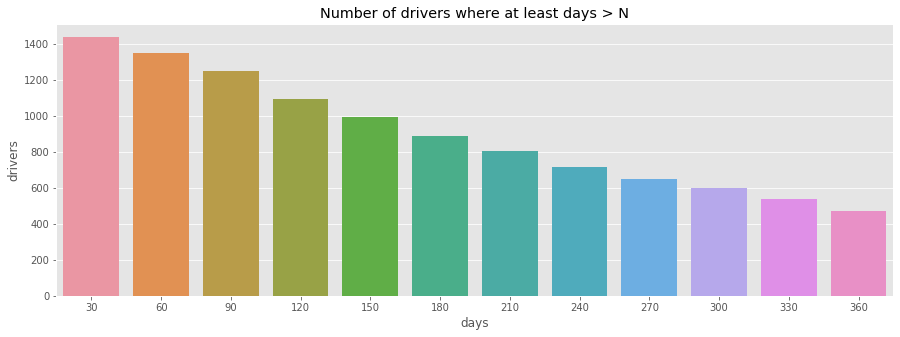

In [27]:
#print('Drivers in available dataset with:')
#for rdays in [(i+1)*30 for i in range(12)]:
#    print('More than {} days: {} ({:0.1f}%)'.format(rdays, sum(df.days > rdays), 100*sum(df.days > rdays)/df.shape[0]))
plt.figure(figsize=(15, 5))
y = [sum(df.days > rdays) for rdays in [(i+1)*30 for i in range(12)]]
x = [rdays for rdays in [(i+1)*30 for i in range(12)]]
sns.barplot(x, y);
plt.title('Number of drivers where at least days > N');
plt.xlabel('days');
plt.ylabel('drivers');

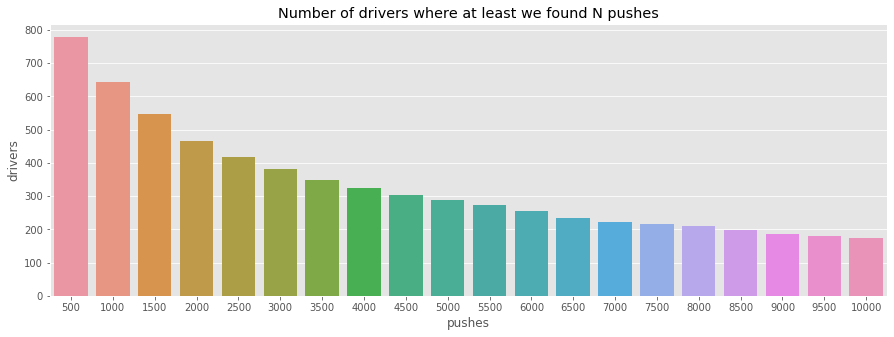

In [28]:
plt.figure(figsize=(15, 5))
y = [sum(df.pushes > p) for p in [(i+1)*500 for i in range(20)]]
x = [p for p in [(i+1)*500 for i in range(20)]]
sns.barplot(x, y);
plt.title('Number of drivers where at least we found N pushes');
plt.xlabel('pushes');
plt.ylabel('drivers');

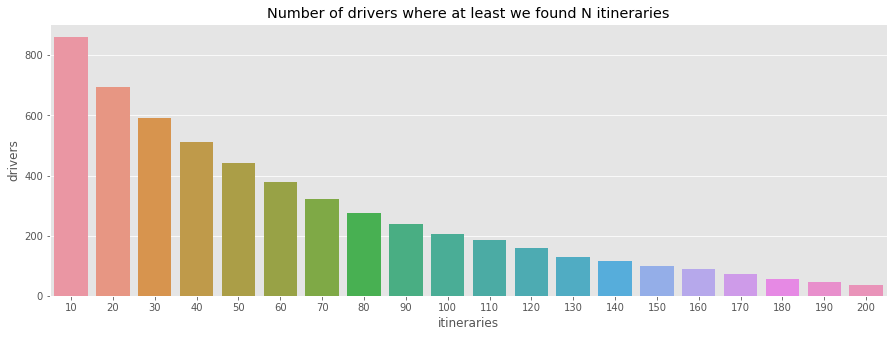

In [29]:
plt.figure(figsize=(15, 5))
y = [sum(df.itineraries > p) for p in [(i+1)*10 for i in range(20)]]
x = [p for p in [(i+1)*10 for i in range(20)]]
sns.barplot(x, y);
plt.title('Number of drivers where at least we found N itineraries');
plt.xlabel('itineraries');
plt.ylabel('drivers');

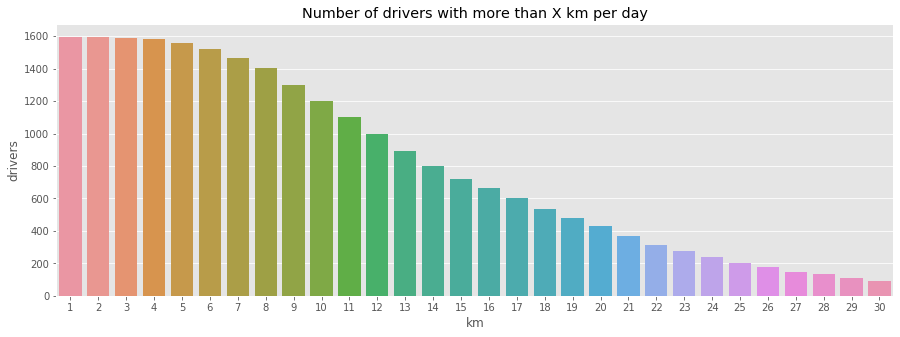

In [30]:
plt.figure(figsize=(15, 5))
y = [sum(df.avg_day_distance > p) for p in [(i+1)*1 for i in range(30)]]
x = [p for p in [(i+1)*1 for i in range(30)]]
sns.barplot(x, y);
plt.title('Number of drivers with more than X km per day');
plt.xlabel('km');
plt.ylabel('drivers');

### Next plot will require an observation in detail

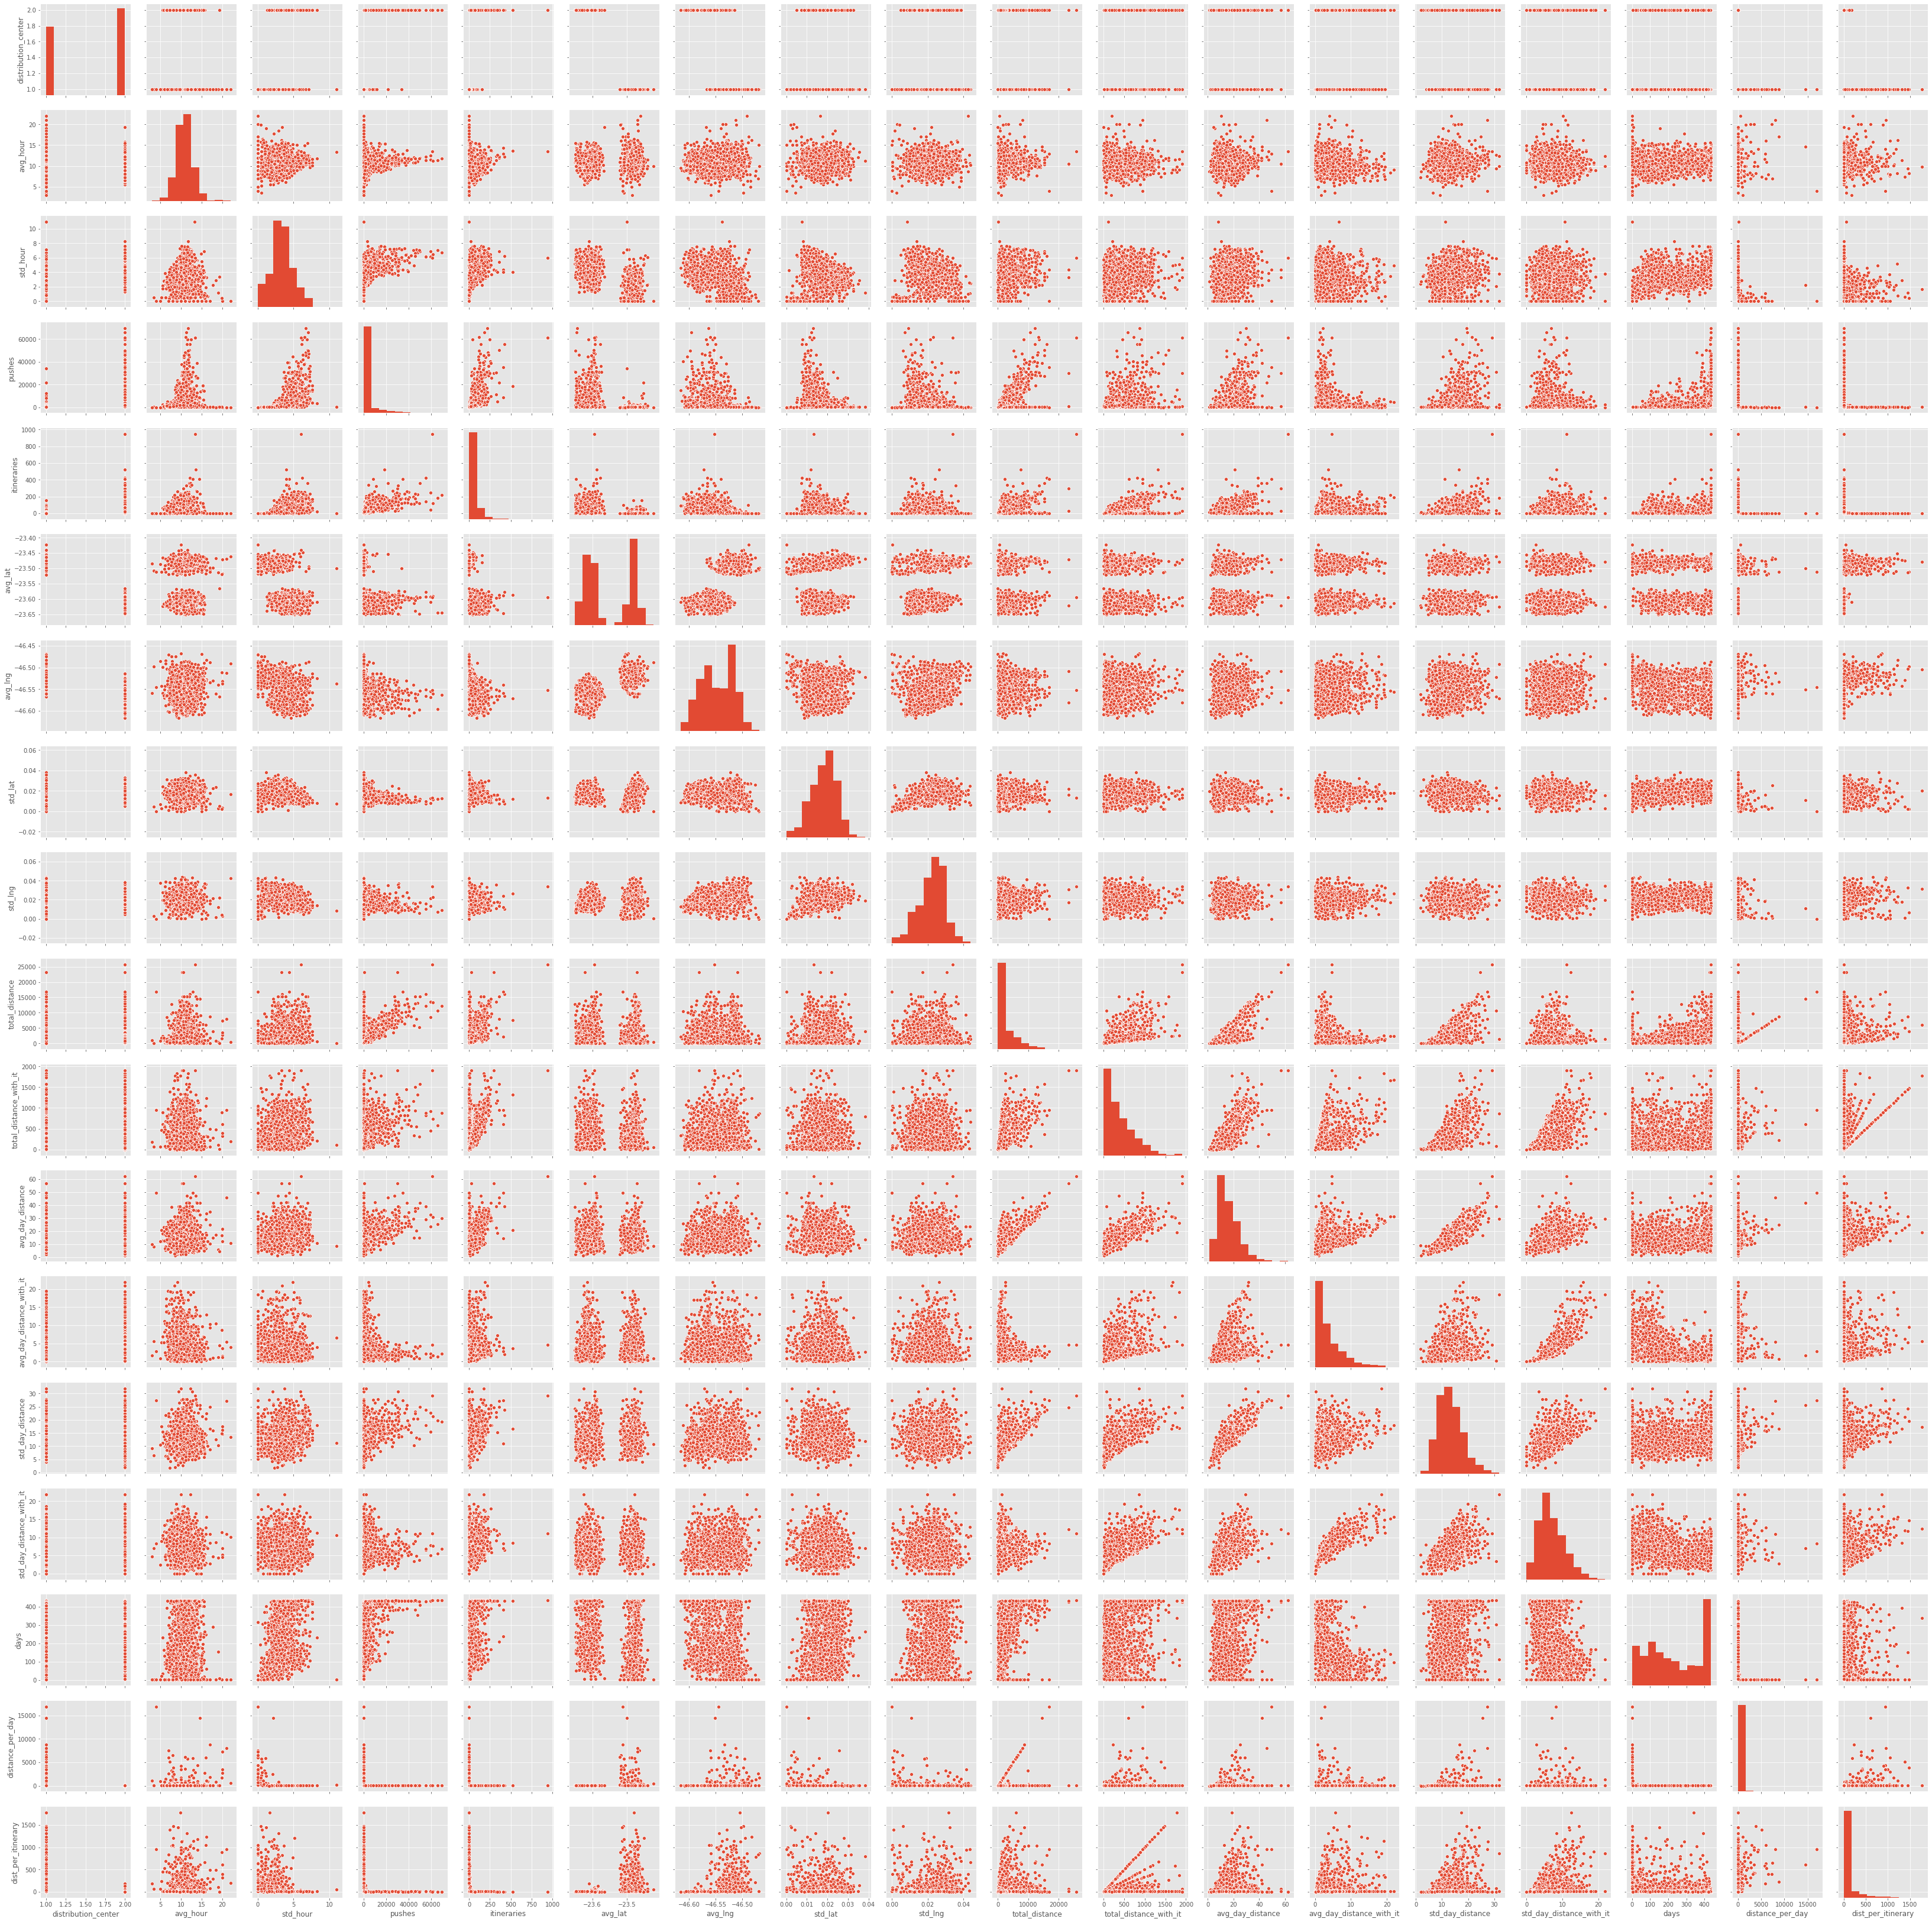

In [31]:
sns.pairplot(data=df);

In [32]:
# we add the latitude and longitude variations
df['near_driver'] = df['std_lat'] + df['std_lng']
df['near_driver'] = df['near_driver'].apply(lambda x: (x - df['near_driver'].mean()) / df['near_driver'].std())
df['near_driver'] = df['near_driver'].abs()
df['near_driver'][df['near_driver'].isna()] = 0
df['near_driver'] = df['near_driver'].astype('int')
df['near_driver'].unique()

C:\Users\magok\Anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([2, 0, 1, 3])

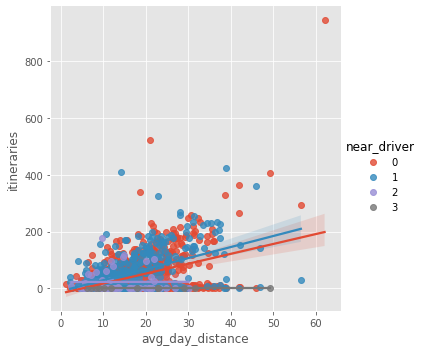

In [33]:
sns.lmplot(x='avg_day_distance', y='itineraries', hue='near_driver', data=df);

### Let see the correlations between the variables

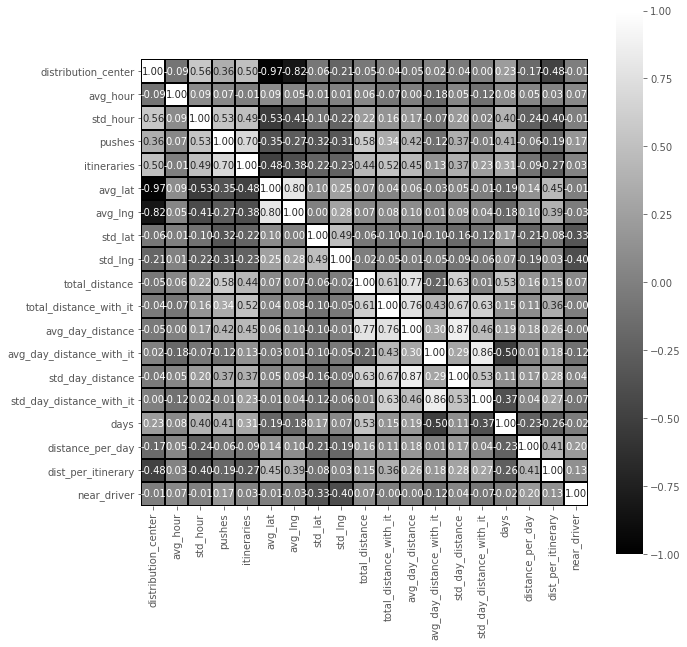

In [34]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

- The number of itineraries is correlated with the number of pushes

### Let's try to plot the avg driver locations

In [35]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    lon = df['avg_lng'].values[:],
    lat = df['avg_lat'].values[:],
    marker = {'size': 5, 'color': 'rgba(255, 100, 100, 0.5)'}))
    
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

### Identify driver by location variance

In [36]:
# we add the latitude and longitude variations
p = df['std_lat'] + df['std_lng']
p = p.apply(lambda x: (x - p.mean()) / p.std())
p = p.abs()
p[p.isna()] = 0
p = p.astype('int')
p.unique()

array([2, 0, 1, 3])

In [38]:
colors = ['rgba(200, 255, 200, 0.7)',
          'rgba(255, 200, 200, 0.7)',
          'rgba(255, 255, 200, 0.7)',
          'rgba(200, 200, 255, 0.7)']

fig = go.Figure()

for s in p.unique():
    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        name = '< {} std'.format(s+1),
        lon = df[p == s]['avg_lng'].values[:],
        lat = df[p == s]['avg_lat'].values[:],
        marker = {'size': 5 + s*10, 'color': colors[s]}))
    
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

### Identidy driver by number of itineraries

In [39]:
p = df['itineraries']
groups = [200, 100, 60, 30, 20, 10, 0]
def classify(x):
    for i, s in enumerate(groups):
        if x >= s: return len(groups)-i-1
    assert(1 == 2)
    
p = p.apply(classify)

In [40]:
mc = {0: 'rgba(000, 255, 255, 0.6)',
      1: 'rgba(000, 255, 255, 0.9)',
      2: 'rgba(255, 200, 200, 0.2)',
      3: 'rgba(255, 150, 150, 0.3)',
      4: 'rgba(255, 150, 150, 0.5)',
      5: 'rgba(255, 150, 150, 0.7)',
      6: 'rgba(255, 100, 100, 0.9)'}
#
fig = go.Figure()

groups.sort()

cls = p.unique()
cls.sort()
for c in cls:
    if c != len(groups)-1:
        name = str(groups[c]) + ' - ' + str(groups[c+1])
    else:
        name = '> ' + str(groups[c])
        
    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        name = name,
        lon = df[p == c]['avg_lng'].values[:],
        lat = df[p == c]['avg_lat'].values[:],
        marker = {'size': 5 + c*2, 'color': mc[c]}))
    
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

### Driver per KM

In [41]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    name = '<= 10 Km daily',
    lon = df[df.avg_day_distance <= 10]['avg_lng'].values[:],
    lat = df[df.avg_day_distance <= 10]['avg_lat'].values[:],
    marker = {'size': 10, 'color': 'red'}))

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    name = '> 10 Km daily',
    lon = df[df.avg_day_distance > 10]['avg_lng'].values[:],
    lat = df[df.avg_day_distance > 10]['avg_lat'].values[:],
    marker = {'size': 10, 'color': 'blue'}))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

In [42]:
df_wh = careful_query("""
select firstlogin.driver_id, firstlogin.firstlogin, lastlogin.lastlogin, (TO_TIMESTAMP(lastlogin.lastlogin, 'HH24:MI:SS')::TIME) - (TO_TIMESTAMP(firstlogin.firstlogin, 'HH24:MI:SS')::TIME) as workinghours
from firstlogin
inner join lastlogin on  firstlogin.driver_id = lastlogin.driver_id
order by workinghours
""")
df_wh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8195 entries, 0 to 8194
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   driver_id     8195 non-null   object         
 1   firstlogin    8195 non-null   object         
 2   lastlogin     8195 non-null   object         
 3   workinghours  8195 non-null   timedelta64[ns]
dtypes: object(3), timedelta64[ns](1)
memory usage: 256.2+ KB


In [43]:
df = df.merge(df_wh, left_on='driver_id', right_on='driver_id')

In [44]:
df['firstlogin'] = pd.to_datetime(df['firstlogin'])
df['lastlogin'] = pd.to_datetime(df['lastlogin'])

In [45]:
df['total_seconds'] = df.workinghours.apply(lambda x: x.total_seconds())

In [46]:
df['total_hours'] = df['total_seconds']/3600

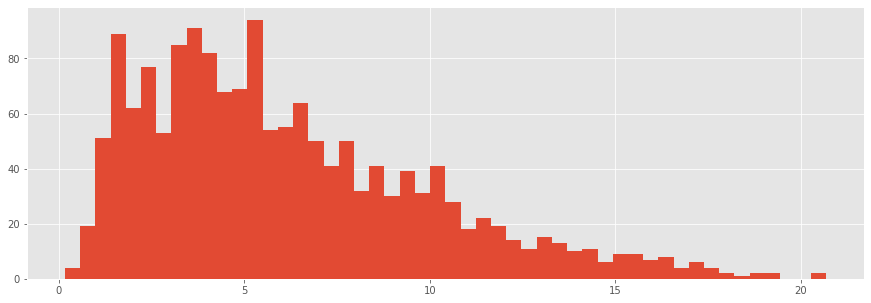

In [47]:
df['total_hours'].hist(bins=50, figsize=(15,5));

In [48]:
df['first_hour'] = df['firstlogin'].apply(lambda x: x.hour)
df['last_hour'] = df['lastlogin'].apply(lambda x: x.hour)

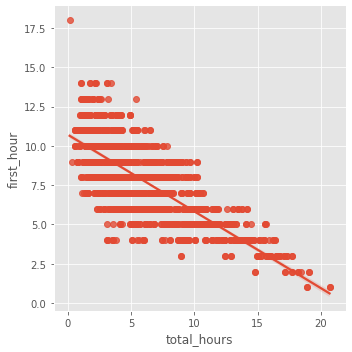

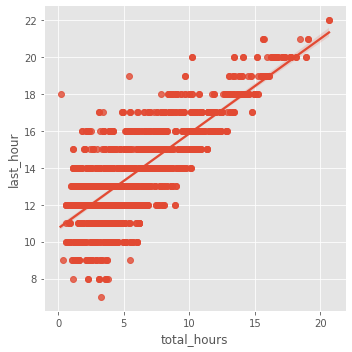

In [49]:
sns.lmplot(x='total_hours', y='first_hour', data=df)
plt.show()
sns.lmplot(x='total_hours', y='last_hour', data=df)

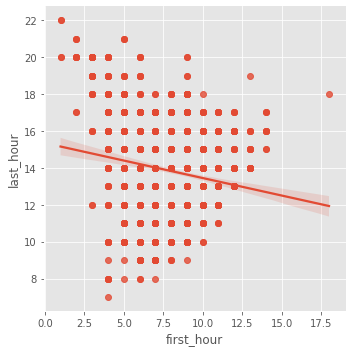

In [50]:
sns.lmplot(x='first_hour', y='last_hour', data=df);

In [51]:
l = [i+3 for i in list(df.first_hour.unique())]
l.sort()
l

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21]

In [52]:
l = [i+3 for i in list(df.last_hour.unique())]
l.sort()
l

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

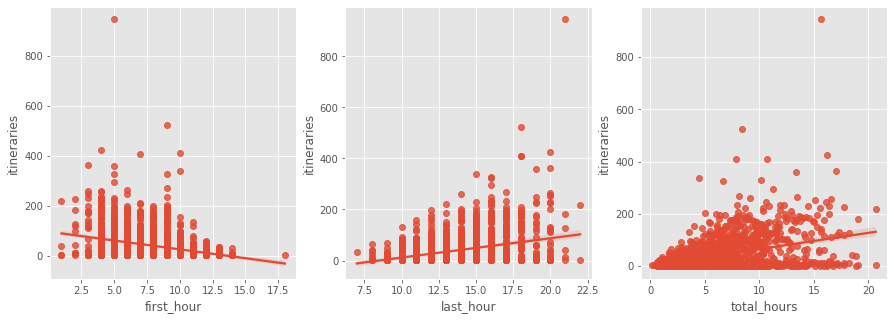

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, col in enumerate(['first_hour', 'last_hour', 'total_hours']):
    sns.regplot(x=col, y='itineraries', data=df, ax=axes[i]);

In [54]:
df[['first_hour', 'last_hour', 'total_hours']].corr()

first_hour  last_hour  total_hours
first_hour     1.000000  -0.185378    -0.755734
last_hour     -0.185378   1.000000     0.775182
total_hours   -0.755734   0.775182     1.000000

In [55]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    name = '<= 6 working hours',
    lon = df[df.total_hours <= 6]['avg_lng'].values[:],
    lat = df[df.total_hours <= 6]['avg_lat'].values[:],
    marker = {'size': 10, 'color': 'red'}))

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    name = '> 6 working hours',
    lon = df[df.total_hours > 6]['avg_lng'].values[:],
    lat = df[df.total_hours > 6]['avg_lat'].values[:],
    marker = {'size': 10, 'color': 'green'}))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

In [56]:
tdf = df[['itineraries', 'total_hours', 'pushes']].copy()

In [57]:
tdf['log_itineraries'] = np.log(tdf.itineraries+1)

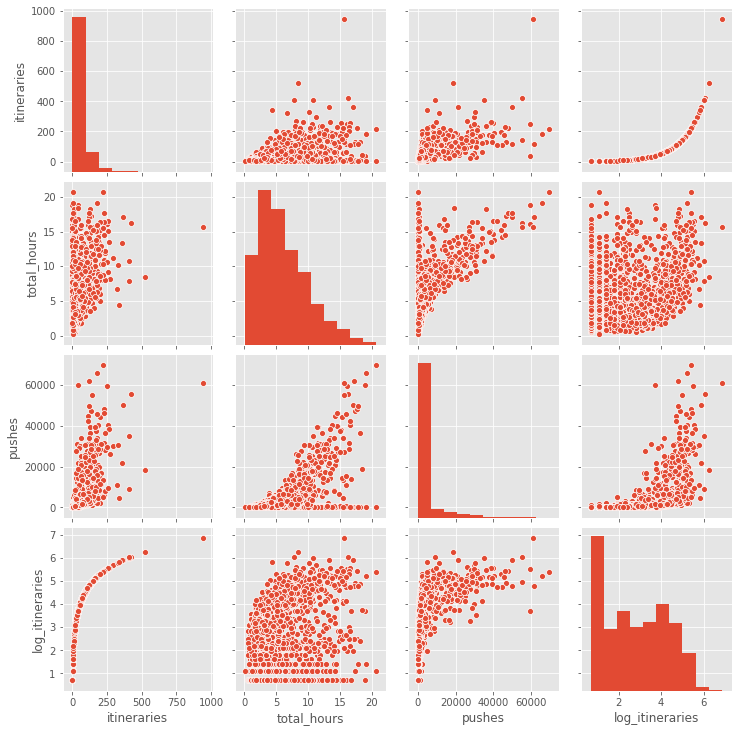

In [58]:
sns.pairplot(tdf);

In [59]:
tdf.corr()

itineraries  total_hours    pushes  log_itineraries
itineraries         1.000000     0.381565  0.695261         0.781295
total_hours         0.381565     1.000000  0.547351         0.270158
pushes              0.695261     0.547351  1.000000         0.564645
log_itineraries     0.781295     0.270158  0.564645         1.000000

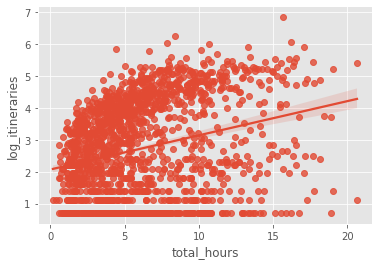

In [60]:
sns.regplot(x='total_hours', y='log_itineraries', data=tdf);